In [25]:
IDD = '../eeg_dataset/Data/CleanData/CleanData_IDD/Rest'
IDC = '../eeg_dataset/Data/CleanData/CleanData_TDC/Rest'

In [26]:
from glob import glob
import scipy.io
import torch
import torch.nn as nn
import numpy as np
import torchmetrics
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

In [27]:
for idd in glob(IDC+'/*.mat'):
    data = scipy.io.loadmat(idd)
    break

In [28]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'clean_data'])

In [29]:
data = data['clean_data']
data.shape

(14, 15360)

In [30]:
import mne

In [31]:
n_channels=14
sampling_freq = 128
info = mne.create_info(n_channels, sfreq=sampling_freq)
print(info)

<Info | 7 non-empty values
 bads: []
 ch_names: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13
 chs: 14 misc
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 14
 projs: []
 sfreq: 128.0 Hz
>


In [32]:
ch_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
ch_types = ['eeg'] * 14
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
info.set_montage('standard_1020')

<Info | 8 non-empty values
 bads: []
 ch_names: AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6, F4, F8, AF4
 chs: 14 EEG
 custom_ref_applied: False
 dig: 17 items (3 Cardinal, 14 EEG)
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 14
 projs: []
 sfreq: 128.0 Hz
>

In [33]:
data = mne.io.RawArray(data, info)

Creating RawArray with float64 data, n_channels=14, n_times=15360
    Range : 0 ... 15359 =      0.000 ...   119.992 secs
Ready.


In [34]:
# data.filter(l_freq=1, h_freq=30)

In [35]:
data

<RawArray | 14 x 15360 (120.0 s), ~1.7 MiB, data loaded>

In [36]:
epochs = mne.make_fixed_length_epochs(data, duration=4, overlap=0)

Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


In [37]:
epochs.get_data().shape

Using data from preloaded Raw for 30 events and 512 original time points ...
0 bad epochs dropped


(30, 14, 512)

In [38]:
def convertmat2mne(data):
    ch_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
    ch_types = ['eeg'] * 14
    info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
    info.set_montage('standard_1020')
    data = mne.io.RawArray(data, info)
    data.set_eeg_reference()
    data.filter(l_freq=1, h_freq=30)
    epochs = mne.make_fixed_length_epochs(data, duration=4, overlap=0)
    
    return epochs.get_data()

In [39]:
%%capture
idd_subject = []
for idd in glob(IDD+'/*.mat'):
    data = scipy.io.loadmat(idd)['clean_data']
    data = convertmat2mne(data)
    idd_subject.append(data)

In [40]:
%%capture
tdc_subject = []
for idc in glob(IDC+'/*.mat'):
    data = scipy.io.loadmat(idc)['clean_data']
    data = convertmat2mne(data)
    tdc_subject.append(data)

In [41]:
len(idd_subject), len(tdc_subject)

(7, 7)

In [42]:
healthy_epochs_label = [len(i)*[0] for i in tdc_subject]
patient_epochs_label = [len(i)*[1] for i in idd_subject]

In [43]:
print(len(healthy_epochs_label), len(patient_epochs_label))

7 7


In [44]:
data_list = tdc_subject + idd_subject
label_list = healthy_epochs_label + patient_epochs_label

In [45]:
print(len(data_list), len(label_list))

14 14


In [46]:
groups_list = [[i]*len(j) for i, j in enumerate(data_list)]

In [47]:
data_array = np.vstack(data_list)
label_array = np.hstack(label_list)
group_array = np.hstack(groups_list)
data_array = np.moveaxis(data_array, 1, 2)

print(data_array.shape, label_array.shape, group_array.shape)

(420, 512, 14) (420,) (420,)


In [48]:
class Block(nn.Module):
    def __init__(self, inplace):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=inplace, out_channels=32, kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv1d(in_channels=inplace, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv1d(in_channels=inplace, out_channels=32, kernel_size=8, stride=2, padding=3)
        self.relu = nn.ReLU()
          
    def forward(self, x):
        x1 = self.relu(self.conv1(x))
        x2 = self.relu(self.conv2(x))
        x3 = self.relu(self.conv3(x))
        x = torch.cat([x1, x2, x3], dim=1)
        return x

In [49]:
class ChronoNet(nn.Module):
    def __init__(self, channel):
        super().__init__()
        self.block1 = Block(channel)
        self.block2 = Block(96)
        self.block3 = Block(96)
        
        self.gru1 = nn.GRU(input_size=96, hidden_size=32, batch_first=True)
        self.gru2 = nn.GRU(input_size=32, hidden_size=32, batch_first=True)
        self.gru3 = nn.GRU(input_size=64, hidden_size=32, batch_first=True)
        self.gru4 = nn.GRU(input_size=96, hidden_size=32, batch_first=True)
        
        self.gru_linear = nn.Linear(64, 1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        
        x = x.permute(0, 2, 1)
        
        gru_out1, _ = self.gru1(x)
        gru_out2, _ = self.gru2(gru_out1)
        gru_out = torch.cat([gru_out1, gru_out2], dim=2)
        gru_out3, _ = self.gru3(gru_out)
        gru_out = torch.cat([gru_out1, gru_out2, gru_out3], dim=2)
        linear_out = self.relu(self.gru_linear(gru_out.permute(0, 2, 1))) 
        gru_out4, _ = self.gru4(linear_out.permute(0, 2, 1))
        
        x = self.flatten(gru_out4) 
        x = self.fc1(x)
        
        return x

In [50]:
import torch
import torch.nn as nn

class ChronoNetRNN(nn.Module):
    def __init__(self, channel):
        super().__init__()
        self.block1 = Block(channel)
        self.block2 = Block(96)
        self.block3 = Block(96)
        
        # Replace LSTM with RNN
        self.rnn1 = nn.RNN(input_size=96, hidden_size=32, batch_first=True)
        self.rnn2 = nn.RNN(input_size=32, hidden_size=32, batch_first=True)
        self.rnn3 = nn.RNN(input_size=64, hidden_size=32, batch_first=True)
        self.rnn4 = nn.RNN(input_size=96, hidden_size=32, batch_first=True)
        
        self.rnn_linear = nn.Linear(64, 1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        
        x = x.permute(0, 2, 1)  # (batch, seq_len, channel)
        
        rnn_out1, _ = self.rnn1(x)
        rnn_out2, _ = self.rnn2(rnn_out1)
        rnn_out = torch.cat([rnn_out1, rnn_out2], dim=2)
        rnn_out3, _ = self.rnn3(rnn_out)
        rnn_out = torch.cat([rnn_out1, rnn_out2, rnn_out3], dim=2)
        
        linear_out = self.relu(self.rnn_linear(rnn_out.permute(0, 2, 1))) 
        rnn_out4, _ = self.rnn4(linear_out.permute(0, 2, 1))
        
        x = self.flatten(rnn_out4)
        x = self.fc1(x)
        
        return x

In [51]:
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin, BaseEstimator

In [52]:
class StandardScaler3D(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        
    def fit(self, x, y=None):
        self.scaler.fit(x.reshape(-1, x.shape[2]))
        return self

    def transform(self, x):
        return self.scaler.transform(x.reshape(-1, x.shape[2])).reshape(x.shape)

In [53]:
data_array = np.concatenate(data_list)
label_array = np.concatenate(label_list)
group_array = np.concatenate(groups_list)
data_array = np.moveaxis(data_array, 1, 2)

print(data_array.shape, label_array.shape, group_array.shape)

(420, 512, 14) (420,) (420,)


In [54]:
len(data_array[1])

512

In [55]:
gkf = GroupKFold(n_splits=4)

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
accuracy = []

for train_index, val_index in gkf.split(data_array, label_array, groups=group_array):
    train_features,train_labels=data_array[train_index],label_array[train_index]
    val_features,val_labels=data_array[val_index],label_array[val_index]
    
    scaler=StandardScaler3D()
    
    train_features=scaler.fit_transform(train_features)
    val_features=scaler.transform(val_features)
    train_features=np.moveaxis(train_features,1,2)
    val_features=np.moveaxis(val_features,1,2)
    
    break

In [57]:
train_features = torch.Tensor(train_features)
val_features = torch.Tensor(val_features)
train_labels = torch.Tensor(train_labels)
val_labels = torch.Tensor(val_labels)

In [58]:
train_features.shape, val_features.shape

(torch.Size([300, 14, 512]), torch.Size([120, 14, 512]))

In [59]:
len(val_features),len(val_labels)

(120, 120)

In [60]:
train_features.shape

torch.Size([300, 14, 512])

In [61]:
from pytorch_lightning import LightningModule,Trainer
import torchmetrics
from torch.utils.data import TensorDataset,DataLoader

In [62]:
class ChronoModel(LightningModule):
    def __init__(self):
        super(ChronoModel, self).__init__()
        self.model = ChronoNetRNN(14)

        self.lr = 1e-4
        self.bs = 64
        self.worker = 2

        self.criterion = nn.BCEWithLogitsLoss()
        self.acc_metric = torchmetrics.classification.BinaryAccuracy()

        # Buffers to collect metrics
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def train_dataloader(self):
        dataset = TensorDataset(train_features, train_labels)
        return DataLoader(dataset, batch_size=self.bs, shuffle=True, num_workers=self.worker)

    def val_dataloader(self):
        dataset = TensorDataset(val_features, val_labels)
        return DataLoader(dataset, batch_size=self.bs, shuffle=True, num_workers=self.worker)

    def training_step(self, batch, batch_idx):
        signal, label = batch
        out = self(signal.float())
        loss = self.criterion(out.flatten(), label.float().flatten())
        acc = self.acc_metric(torch.sigmoid(out).flatten(), label.int().flatten())
        
        self.train_losses.append(loss.detach().cpu())
        self.train_accuracies.append(acc.detach().cpu())
        
        return loss

    def on_train_epoch_end(self):
        avg_loss = torch.stack(self.train_losses).mean().item()
        avg_acc = torch.stack(self.train_accuracies).mean().item()
        print(f"[Train] Epoch End — Loss: {avg_loss:.4f}, Acc: {avg_acc:.4f}")
        self.train_losses.clear()
        self.train_accuracies.clear()

    def validation_step(self, batch, batch_idx):
        signal, label = batch
        out = self(signal.float())
        loss = self.criterion(out.flatten(), label.float().flatten())
        acc = self.acc_metric(torch.sigmoid(out).flatten(), label.int().flatten())
        
        self.val_losses.append(loss.detach().cpu())
        self.val_accuracies.append(acc.detach().cpu())

        return loss

    def on_validation_epoch_end(self):
        avg_loss = torch.stack(self.val_losses).mean().item()
        avg_acc = torch.stack(self.val_accuracies).mean().item()
        print(f"[Val] Epoch End — Loss: {avg_loss:.4f}, Acc: {avg_acc:.4f}")
        self.val_losses.clear()
        self.val_accuracies.clear()


In [63]:
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

In [75]:
from pytorch_lightning import LightningModule
import torch
import torch.nn as nn
import torchmetrics
from torch.utils.data import DataLoader, TensorDataset

class ChronoModel(LightningModule):
    def __init__(self):
        super(ChronoModel, self).__init__()
        self.model = ChronoNet(14)  # make sure ChronoNet is defined elsewhere

        self.lr = 1e-4
        self.bs = 64
        self.worker = 2

        self.criterion = nn.BCEWithLogitsLoss()
        self.acc_metric = torchmetrics.classification.BinaryAccuracy()

        # Buffers to collect batch metrics
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def train_dataloader(self):
        dataset = TensorDataset(train_features, train_labels)  # Make sure these are defined globally
        return DataLoader(dataset, batch_size=self.bs, shuffle=True, num_workers=self.worker)

    def val_dataloader(self):
        dataset = TensorDataset(val_features, val_labels)
        return DataLoader(dataset, batch_size=self.bs, shuffle=True, num_workers=self.worker)

    def training_step(self, batch, batch_idx):
        signal, label = batch
        out = self(signal.float())
        loss = self.criterion(out.flatten(), label.float().flatten())
        acc = self.acc_metric(torch.sigmoid(out).flatten(), label.int().flatten())

        self.train_losses.append(loss.detach().cpu())
        self.train_accuracies.append(acc.detach().cpu())

        return loss

    def on_train_epoch_end(self):
        avg_loss = torch.stack(self.train_losses).mean().item()
        avg_acc = torch.stack(self.train_accuracies).mean().item()
        
        train_loss_history.append(avg_loss)
        train_acc_history.append(avg_acc)

        print(f"[Train] Epoch End — Loss: {avg_loss:.4f}, Acc: {avg_acc:.4f}")
        self.train_losses.clear()
        self.train_accuracies.clear()

    def validation_step(self, batch, batch_idx):
        signal, label = batch
        out = self(signal.float())
        loss = self.criterion(out.flatten(), label.float().flatten())
        acc = self.acc_metric(torch.sigmoid(out).flatten(), label.int().flatten())

        self.val_losses.append(loss.detach().cpu())
        self.val_accuracies.append(acc.detach().cpu())

        return loss

    def on_validation_epoch_end(self):
        avg_loss = torch.stack(self.val_losses).mean().item()
        avg_acc = torch.stack(self.val_accuracies).mean().item()

        val_loss_history.append(avg_loss)
        val_acc_history.append(avg_acc)

        print(f"[Val] Epoch End — Loss: {avg_loss:.4f}, Acc: {avg_acc:.4f}")
        self.val_losses.clear()
        self.val_accuracies.clear()


In [77]:
import matplotlib.pyplot as plt
from pytorch_lightning import Trainer
import torch


train_loss_history.clear()
train_acc_history.clear()
val_loss_history.clear()
val_acc_history.clear()

model = ChronoModel()
num_epochs = 20

trainer = Trainer(max_epochs=num_epochs)
trainer.fit(model)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | model      | ChronoNet         | 133 K  | train
1 | criterion  | BCEWithLogitsLoss | 0      | train
2 | acc_metric | BinaryAccuracy    | 0      | train
---------------------------------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.534     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

[Val] Epoch End — Loss: 0.6935, Acc: 0.5067


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[Val] Epoch End — Loss: 0.6936, Acc: 0.5011
[Train] Epoch End — Loss: 0.6931, Acc: 0.5057


Validation: |          | 0/? [00:00<?, ?it/s]

[Val] Epoch End — Loss: 0.6936, Acc: 0.5000
[Train] Epoch End — Loss: 0.6924, Acc: 0.5091


Validation: |          | 0/? [00:00<?, ?it/s]

[Val] Epoch End — Loss: 0.6938, Acc: 0.4922
[Train] Epoch End — Loss: 0.6920, Acc: 0.5065


Validation: |          | 0/? [00:00<?, ?it/s]

[Val] Epoch End — Loss: 0.6935, Acc: 0.4989
[Train] Epoch End — Loss: 0.6912, Acc: 0.5023


Validation: |          | 0/? [00:00<?, ?it/s]

[Val] Epoch End — Loss: 0.6933, Acc: 0.4989
[Train] Epoch End — Loss: 0.6899, Acc: 0.5128


Validation: |          | 0/? [00:00<?, ?it/s]

[Val] Epoch End — Loss: 0.6929, Acc: 0.5011
[Train] Epoch End — Loss: 0.6877, Acc: 0.5611


Validation: |          | 0/? [00:00<?, ?it/s]

[Val] Epoch End — Loss: 0.6923, Acc: 0.5000
[Train] Epoch End — Loss: 0.6852, Acc: 0.5952


Validation: |          | 0/? [00:00<?, ?it/s]

[Val] Epoch End — Loss: 0.6913, Acc: 0.5078
[Train] Epoch End — Loss: 0.6808, Acc: 0.7102


Validation: |          | 0/? [00:00<?, ?it/s]

[Val] Epoch End — Loss: 0.6898, Acc: 0.5056
[Train] Epoch End — Loss: 0.6744, Acc: 0.7841


Validation: |          | 0/? [00:00<?, ?it/s]

[Val] Epoch End — Loss: 0.6869, Acc: 0.6384
[Train] Epoch End — Loss: 0.6650, Acc: 0.8722


Validation: |          | 0/? [00:00<?, ?it/s]

[Val] Epoch End — Loss: 0.6822, Acc: 0.6696
[Train] Epoch End — Loss: 0.6507, Acc: 0.9659


Validation: |          | 0/? [00:00<?, ?it/s]

[Val] Epoch End — Loss: 0.6754, Acc: 0.7087
[Train] Epoch End — Loss: 0.6304, Acc: 0.9781


Validation: |          | 0/? [00:00<?, ?it/s]

[Val] Epoch End — Loss: 0.6654, Acc: 0.7076
[Train] Epoch End — Loss: 0.6047, Acc: 0.9969


Validation: |          | 0/? [00:00<?, ?it/s]

[Val] Epoch End — Loss: 0.6521, Acc: 0.7980
[Train] Epoch End — Loss: 0.5711, Acc: 0.9969


Validation: |          | 0/? [00:00<?, ?it/s]

[Val] Epoch End — Loss: 0.6325, Acc: 0.7612
[Train] Epoch End — Loss: 0.5335, Acc: 0.9969


Validation: |          | 0/? [00:00<?, ?it/s]

[Val] Epoch End — Loss: 0.6095, Acc: 0.8326
[Train] Epoch End — Loss: 0.4903, Acc: 0.9969


Validation: |          | 0/? [00:00<?, ?it/s]

[Val] Epoch End — Loss: 0.5811, Acc: 0.8493
[Train] Epoch End — Loss: 0.4457, Acc: 1.0000


Validation: |          | 0/? [00:00<?, ?it/s]

[Val] Epoch End — Loss: 0.5516, Acc: 0.8895
[Train] Epoch End — Loss: 0.3995, Acc: 1.0000


Validation: |          | 0/? [00:00<?, ?it/s]

[Val] Epoch End — Loss: 0.5203, Acc: 0.8940
[Train] Epoch End — Loss: 0.3573, Acc: 1.0000


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


[Val] Epoch End — Loss: 0.4884, Acc: 0.8850
[Train] Epoch End — Loss: 0.3191, Acc: 1.0000


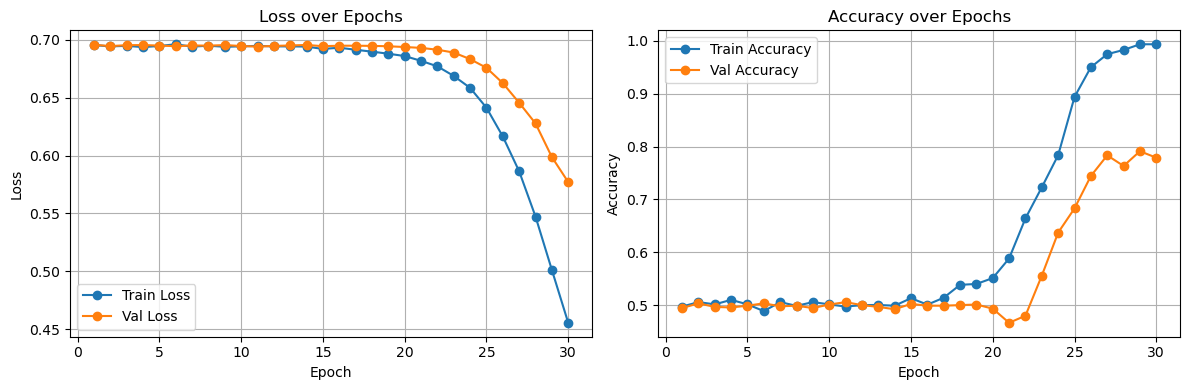

In [69]:
import matplotlib.pyplot as plt

val_loss_history.pop(0)
val_acc_history.pop(0)

# Ensure the length of histories match num_epochs
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(12, 4))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, label="Train Loss", marker='o')
plt.plot(epochs, val_loss_history, label="Val Loss", marker='o')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_history, label="Train Accuracy", marker='o')
plt.plot(epochs, val_acc_history, label="Val Accuracy", marker='o')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
